In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as pl
import ipdb
import platform
import h5py
import scipy.io
opj = os.path.join
deb = ipdb.set_trace

# MRI imports
# -----------
import nibabel as nb
import cortex

# Bokeh imports
# -------------
from bokeh.io import output_notebook, show, save, output_file, export_png, export_svgs
from bokeh.layouts import row, column, gridplot

# Popeye imports
# --------------
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.css as css
import popeye.og as og

# Get inputs
# ----------
subject = '999999'
fit_model = 'gauss'
draw_hemi = 1

In [2]:
# Define analysis parameters
# --------------------------
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
    
# Define cluster/server specific parameters
# -----------------------------------------
if 'aeneas' in platform.uname()[1]:
    base_dir = analysis_info['aeneas_base_folder'] 
elif 'local' in platform.uname()[1]:
    base_dir = analysis_info['local_base_folder'] 
    
h5_dir = opj(base_dir,'pp_data',subject,fit_model,'h5')
base_file_name = 'tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries'
roi_masks_dir = opj(base_dir,'pp_data',subject,fit_model,'roi_masks')
sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11
    
# Create stimulus design and define model
visual_dm_file = scipy.io.loadmat(opj(base_dir,'raw_data','retinotopysmall5.mat'))
visual_dm = visual_dm_file['stim']

stimulus = VisualStimulus(  stim_arr = visual_dm,
                            viewing_distance = analysis_info["screen_distance"],
                            screen_width = analysis_info["screen_width"],
                            scale_factor = 1/10.0,
                            tr_length = analysis_info["TR"],
                            dtype = np.short)


if fit_model == 'gauss':
    fit_func = og.GaussianFit
    num_est = 6
    model_func = og.GaussianModel(  stimulus = stimulus,
                                    hrf_model = utils.spm_hrf)
elif fit_model == 'css':
    fit_func = css.CompressiveSpatialSummationFit
    num_est = 7
    model_func = css.CompressiveSpatialSummationModel(  stimulus = stimulus,
                                                        hrf_model = utils.spm_hrf)
model_func.hrf_delay = 0


In [3]:
# load time course data
# load prf deriv data
# create model time course
# load masks
# save per mask the time course recorded and modeled
# plot time course for each vertex
# plot time course for each vertex ordered by rsq
# plot time course for each vertex ordered by amplitude & rsq
# plot time course for each vertex ordered by eccentricity & rsq
# plot time course for each vertex ordered by baseline & rsq
# plot time course for each vertex ordered by non-linearity & rsq
# plot time course for each vertex ordered by prf coverage & rsq

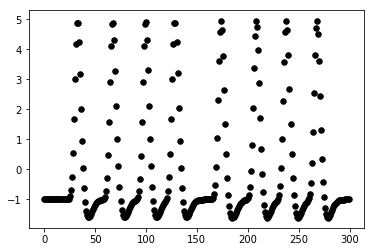

In [4]:
x = -1.0
y = 1
sigma = 1.24
hrf_delay = 0
beta = 0.55
baseline = 0.0000001

## create the time-series for the invented pRF estimate
data = model_func.generate_prediction(x, y, sigma, model_func.hrf_delay, beta, baseline)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.scatter(range(len(data)),data,s=30,c='k',label='data',zorder=2)
plt.show()

In [10]:
# Draw main analysis figure
# -------------------------
print('creating bokeh time course plots')

# Initialize data dictionary that will save all data arrays

for hemi in ['L']:#['L', 'R', 'LR']:

    # load roi masks
    if hemi == 'L' or hemi == 'R':
        mask_file = opj(roi_masks_dir,"masks_{hemi}.func.gii".format(hemi = hemi))
        gii_in_mask = nb.load(mask_file)
        mask_mat = np.array([gii_in_mask.darrays[i].data for i in range(len(gii_in_mask.darrays))])
    
        # load time course of original data
        orig_data_file  =  sorted(glob.glob(opj(base_dir,'raw_data',subject,'*RETBAR1_7T*%s.func_bla_psc_av.gii'% hemi)))
        orig_data_file_load = nb.load(orig_data_file[0])
        orig_data = []
        orig_data.append(np.array([orig_data_file_load.darrays[i].data for i in range(len(orig_data_file_load.darrays))]))
        orig_data = np.vstack(orig_data)

    for roi_num, roi in enumerate(analysis_info['rois']):
        roi_text = roi
        
        for mask_dir in ['all','pos','neg']:
            deriv_mat_hemi = []
            tc_mat_hemi = []
            val_hemi = 0
            for hemi in ['L', 'R', 'LR']:
                # load data
                if hemi == 'LR':
                    deriv_mat = np.row_stack((deriv_mat_hemi[0],deriv_mat_hemi[1]))
                    draw = True
                else:

                    if hemi == 'L': val_hemi = 1
                    elif hemi == 'R': val_hemi = 2

                    # select corresponding time course
                    mask_mat_roi = mask_mat[roi_num,:]
                    mask_mat_roi = np.round(mask_mat_roi)
                    tc_mat = orig_data[:, mask_mat_roi==1].T
                    tc_mat_hemi.append(tc_mat)
                        
                    # load derivatives
                    folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
                    h5_file = h5py.File(opj(h5_dir,'{roi}.h5'.format(roi = roi_text)), "r")
                    in_file = opj("prf_deriv_{hemi}_{mask_dir}".format(hemi = hemi, mask_dir = mask_dir))
                    deriv_mat = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]
                    deriv_mat = np.vstack((deriv_mat,val_hemi*np.ones((1,deriv_mat.shape[1]))))
                    deriv_mat = deriv_mat[:,:].T
                    deriv_mat_hemi.append(deriv_mat)
                    
                    tc_model_mat = np.zeros((tc_mat.shape))
                    for num_vertex in np.arange(0,tc_mat.shape[0],1):
                        print(num_vertex)
                        tc_model_mat[num_vertex,:] = model_func.generate_prediction( deriv_mat[num_vertex,x_idx], 
                                                                            deriv_mat[num_vertex,y_idx], 
                                                                            deriv_mat[num_vertex,size_idx],
                                                                            model_func.hrf_delay,
                                                                            deriv_mat[num_vertex,amp_idx], 
                                                                            deriv_mat[num_vertex,baseline_idx])
                        
                    
                    
                    # create model tc
                    

                    
                    if draw_hemi == 1:
                        draw = True
                    elif draw_hemi == 0:
                        draw = False
                    
                vertex_ini = data.shape[0]

                
                

creating bokeh time course plots
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

BdbQuit: 

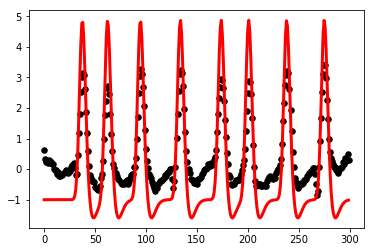

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 
num_vox = 4 
plt.scatter(range(len(tc_mat[num_vox,:])),tc_mat[num_vox,:],s=30,c='k',zorder=2)
plt.plot(range(len(tc_model_mat[num_vox,:])),tc_model_mat[num_vox,:],c='r',lw=3)
plt.show()

In [22]:
deriv_mat[num_vox,baseline_idx]

0.78725457191467285

In [ ]:
# to do
# 1. understand why every plot starts at -1
# 2. make a selection of plots to draw in bokeh
#       plot time course for vertex with high rsq / low rsq
#       combine with                     high amplitude / low amplitude
#       combine with                     high eccentricity / low eccentricity
#       combine with                     high prf coverage / low prf coverage
#       combine with                     high prf non-lin / low prf non-lin
